In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.insert(0, "..")

# Evaluation on the test set and summary

* Here we will eveluate how our model performs on unseen "real world" data by checking its performance against the test set
* We will also look how our model compares to bigger and SOTA models
* Lastly we shall provide a small summary and discuss on various potential improvements
* Also, it's getting quite late so apologies for this spagetio code :D

# Test.tsv evaluation

In [2]:
import joblib
import torch
from torch.utils.data import DataLoader
import numpy as np
from core.model import NER
from core.dataset import NCBIDataset
from core.config import config

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model = NER(3)
my_model.load_state_dict(torch.load("../data/model.bin"))
my_model.to(device)
my_model.eval()
print()

In [6]:
tmp = NCBIDataset(*joblib.load("../data/proc/test.bin"))
tmp_dl = DataLoader(tmp, batch_size = 1, num_workers = 1) 

In [7]:
true_texts = tmp.texts
true_ids = []
true_y_true = []
true_y_hat = []  
with torch.no_grad():
    for data in tmp_dl:  
        for k, v in data.items():  data[k] = v.to(device) 
        out, loss = my_model(data)
       
        mask_1 = data["attention_mask"] == 1
        mask_2 = data["targets"] != -100
        
        true_ids.append(data["input_ids"][mask_1 * mask_2].cpu().numpy()) 
        true_y_true.append(data["targets"][mask_1 * mask_2].cpu().numpy())
        true_y_hat.append(out[mask_1 * mask_2].cpu().numpy())    

In [8]:
assert len(true_texts) == len(true_ids) ==len(true_y_true) ==  len(true_y_hat)

* Unfortunately, I did not find an "agreed" method upon which word piece predictions are combined to get label of main word 
* However, the target of task is to predict label of the word, not its subwords, so as long as we do that anything is fair game.
* So what we will do is take the mean of word pieces logits and assign the label with the highest mean logit 

In [9]:
def is_piece(x:str): return x[:2] == "##" 
def is_full(x:str): return not is_piece(x) 


predictions = []

tok = config["tokenizer"]["TOKENIZER"]
for text, ids, y, y_hat in zip(true_texts, true_ids, true_y_true, true_y_hat): 
    text_t = tok.tokenize(" ".join(text)) + ["XXX"]
    assert len(text_t) - 1 == len(ids) == len(y) == len(y_hat)
   
    idx = 0 
    original_targets = [None for _ in range(len(text))] 
    pooled = []
    for i in range(len(text)):
        
        if is_full(text_t[idx]) and is_full(text_t[idx +1]): 
            original_targets[i] = np.argmax(y_hat[idx])
            idx += 1
            
        elif is_full(text_t[idx]) and is_piece(text_t[idx +1]):
            pooled.append(y_hat[idx])
            idx += 1 
            while is_piece(text_t[idx]): 
                pooled.append(y_hat[idx])
                idx += 1
                
            original_targets[i] = np.argmax(np.mean(np.array(pooled), axis=0))
            pooled = []
            
        elif is_piece(text_t[idx]):
            pooled.append(y_hat[idx])
            idx += 1 
            while is_piece(text[idx]):
                pooled.append(y_hat[idx])
                idx += 1
           
            # add master after piece prefixes 
            pooled.append(y_hat[idx])
            idx += 1
            while is_piece(text_t[idx]):
                pooled.appen(y_hat[idx])
                idx += 1
            original_targets[i] = np.argmax(np.mean(np.array(pooled), axis=0))
            pooled = []               
    
    predictions.append(original_targets)  

In [10]:
targets = tmp.tags
assert len(targets) == len(predictions)
assert sum(len(i) for i in targets) == sum(len(i) for i in predictions)
print(len(targets), len(predictions))  

939 939


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
encoder = joblib.load("../data/label_encoder.bin")

In [12]:
from itertools import chain

In [13]:
_targets = list(chain(*targets))
_predictions = list(chain(*predictions))
assert len(_targets) == len(_predictions)

In [15]:
print(classification_report(_targets, _predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

           B       0.83      0.84      0.84       960
           I       0.84      0.89      0.87      1087
           O       0.99      0.99      0.99     22441

    accuracy                           0.98     24488
   macro avg       0.89      0.91      0.90     24488
weighted avg       0.98      0.98      0.98     24488



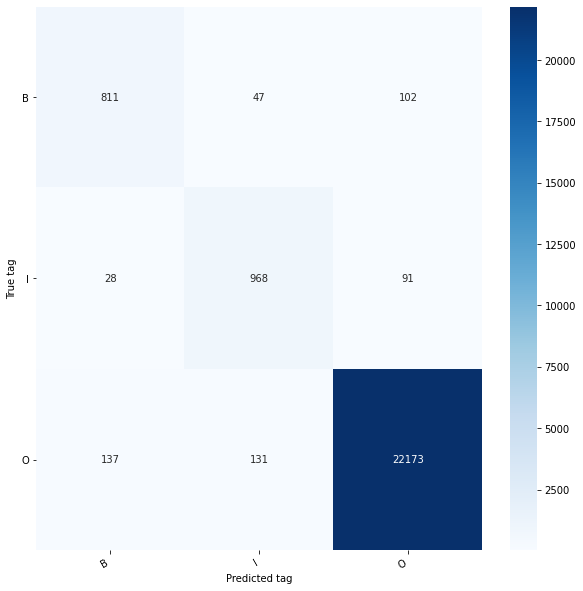

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

cm = pd.DataFrame(confusion_matrix(_targets, _predictions), index = encoder.classes_, columns = encoder.classes_)
plt.figure(figsize=(10,10))
hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True tag')
plt.xlabel('Predicted tag');
plt.show()

---

 Well... the only thing that I don't like more than model not performing is when results are <b> TOO GOOD </b> to be true. Looks like that I would be in it for a huge debugging session, but it would take a bit too long to pin point the exact problems with the pipeline. However, I shall provide my hypotheis on what could be happening:
 
* We got extremely lucky and managed to capture the patterns in the test set due to our fold being very favorable towards the test test <b> HIGHLY UNLIKELY </b> 
* By using few modifications we managed to create a new state of art model by using a much smaller transfer model and I to be hailed as a new hero of NLP <b> EXTREMELY UNLIKELY </b>
* Our pooling process provided additional improvement. But why would other authors not use something like this, I highly doubt that they would not do anything they could do chase that sweeet f1 score <b> EXTREMELY UNLIKELY </b>
* There is a bug splitting the test set. Maybe some dublicates are present in test and training set <b> QUITE LIKELY </b>
* There is some other bug in the code <b> PROBABILITY so high that modern computers would not be able to store it as a floating point representation, even with additional swaps to storage </b>

# Summary

We tried to make a model for predicting diseases for NCBI disease dataset. We downloaded the data, cleaned it up, explored it to select best parameters, split the data into folds, trained the model, optimized it with regards to hyperparameters and did k-folding to achieve higher generalization.

Here is a list of potential improvements that come from the top of my mind:
* Add some cool augmentation techniques for our training set
* Pick some bigger models like bert,xlnet, albert, roberta ... what have you, and see how they do
* Spend additional time looking at data to ensure its validity and clean up stuff
* Do multi-task learning. If we can get part of speech (POS) tags we could also train our model for that to potentially further improve it
* Make loss function mind more attention to diseases. May not be relevant here, but if we, say, have a person and he tells that he has disease X, we would definitely want to catch that so we don't perscribe wrong medicine, and we are okay with getting more misses in favor towards that
* Pre-train the transfer model with domain specific language, as it has been done in [biobert](https://arxiv.org/abs/1901.08746)